<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Можно использовать word2vec и получить вектора, а на них просто уже юзать cnn.

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

LSTM улучшает gradient flow :) 

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

$\frac{d c_{n+1}}{d c_{k}} \sim  \Pi_{i} f_{i} $. Производная взрывается, когда это выражение > 1.

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

BPTT плох, т.к. возводя большие по норме матрицы в степень (или умножая постоянно на них), мы получаем огромные числа, а если на маленькие, то мизерные. Поэтому градиент затухает или взрывается.


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

Обычно в таком сочетании cnn используются как фиче-генератор, а рекуррентные сети строят на основе их, к примеру, описание видео или картинок.

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

Хочется, чтобы поместились все и все были достаточно различными, вообще можно было заюзать word2vec, но я не успел.

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [200]:
!wget https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-05-02 13:50:22--  https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 108.160.172.238
Connecting to www.dropbox.com (www.dropbox.com)|108.160.172.238|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/R8XwLHj2L5LQJpZOljBkA9msy3C3Zbb20TI7wIq8l4R9axuOEqVxcw56u9IVoetA/file [following]
--2017-05-02 13:50:22--  https://dl.dropboxusercontent.com/content_link/R8XwLHj2L5LQJpZOljBkA9msy3C3Zbb20TI7wIq8l4R9axuOEqVxcw56u9IVoetA/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.33.3
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.33.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 482.77M  38.5MB/s    in 13s     

2017-05-02 13:50:36 (36.7 MB/s) - ‘data.tar.gz’ saved

### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 564 ms, sys: 636 ms, total: 1.2 s
Wall time: 835 ms


In [2]:
print("each image code is a 1000-unit vector:", img_codes.shape)
print(img_codes[0,:10])
print('\n\n')
print("for each image there are 5-7 descriptions, e.g.:\n")
print('\n'.join(captions[0]))

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [4]:
from itertools import chain
from collections import Counter
words = list(chain.from_iterable(chain.from_iterable(captions)))

In [5]:
from collections import Counter

In [6]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
word_counts = dict(Counter(words))

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert(10000 <= n_tokens <= 10500)

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[2686, 5100, 4336, 1685, 9807, 1710, 3877, 2824, 7407, 4426, 9416,
        8182, 7813,   -1,   -1],
       [2686, 7407, 4426, 5272, 3303,  631, 8182, 9416, 8049, 6951, 3877,
        7813,   -1,   -1,   -1],
       [2686, 2025, 1685, 9807, 1710, 3877, 2824, 7407, 2744, 9990,  551,
        8055, 9296,  940, 7813],
       [2686, 2025, 4206, 1111, 3607, 8846, 2025, 4206, 6901, 7813,   -1,
          -1,   -1,   -1,   -1],
       [2686, 5100, 4336, 1685, 9807, 1710, 3877, 2824, 7407, 4426,  551,
        8055, 2497, 7813,   -1]], dtype=int32)

### Mah Neural Network

In [58]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 2048 #pls change me if u want

In [67]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *
import lasagne.layers.dnn as lld

In [68]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [69]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
l_word_embeddings = lasagne.layers.EmbeddingLayer(l_words, input_size=n_tokens, output_size=EMBED_SIZE)

In [70]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)
l_image_features_small = DropoutLayer(l_image_features, p=0.25) 
l_image_features_small = DenseLayer(l_image_features_small, num_units=LSTM_UNITS)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [71]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder_1 = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=100)
decoder = LSTMLayer(decoder_1,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=100, backwards=True)
# We'll combine the forward and backward layer output by summing.
# Merge layers take in lists of layers to merge as input.
decoder = lasagne.layers.ElemwiseSumLayer([decoder, decoder_1])

In [72]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print("broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape)

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print("output shape = ", predicted_probabilities.output_shape)

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 2048)
output shape =  (None, None, 10373)


In [73]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
loss = loss[output_mask.nonzero()].mean()


In [74]:
#trainable NN weights
# ############# TO CODE IT BY YOURSELF ##################
l_r = theano.shared(lasagne.utils.floatX(1e-3))
weights = lasagne.layers.get_all_params(predicted_probabilities, trainable=True)
updates = lasagne.updates.adam(loss, weights, learning_rate=l_r)

In [75]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
train_step = theano.function([image_vectors, sentences], loss, updates=updates, allow_input_downcast=True)
val_step   = theano.function([image_vectors, sentences], loss, allow_input_downcast=True)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [76]:
captions = np.array(captions)

In [77]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = list(map(choice, captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [78]:
generate_batch(img_codes,captions, 3)

(array([[ -1.35839319,   1.51204228,   1.0929091 , ...,  -1.89911938,
           0.21276233,   0.74276674],
        [ -3.78559637,  -4.35063267,  -0.35509953, ...,  -2.07486844,
           0.30831838,   0.24216512],
        [  3.17136669,   0.62814784,  10.15747643, ...,  -2.87686753,
          -1.85584438,   0.17976123]], dtype=float32),
 array([[ 2686,  2025,  1994,  3673,  2356,  5456,  4912,  2025,  7678,
           682,  7813,    -1],
        [ 2686,  9450,  7037,  3673,  5272,  3337,  5536,  9416,  2725,
          9725,  7813,    -1],
        [ 2686,  7407, 10190,  8846,  9914,  9416,  1821,  8063,  9388,
          9416,   717,  7813]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [79]:
import requests
def send(text):
    requests.get("https://api.telegram.org/bot224136417:AAGJ2kKaoPiiksBVJ-8AslDTavFDL6btqqE/sendMessage?chat_id=52840743&text=%s" % text)
    requests.get("https://api.telegram.org/bot224136417:AAGJ2kKaoPiiksBVJ-8AslDTavFDL6btqqE/sendMessage?chat_id=78426908&text=%s" % text)

In [80]:
batch_size = 256 #adjust me
n_epochs   = 200 #adjust me
n_batches_per_epoch = 20 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [83]:
l_r.set_value(lasagne.utils.floatX(l_r.get_value() * 10))


100%|██████████| 20/20 [00:45<00:00,  2.22s/it]


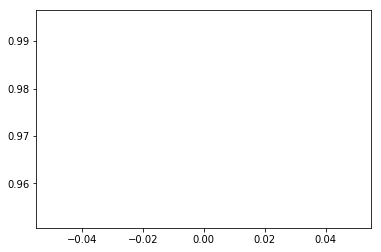


Epoch: 1, train loss: 0.9944069981575012, val loss: 0.9527423620223999


100%|██████████| 20/20 [00:52<00:00,  2.70s/it]


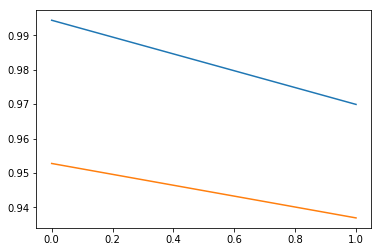


Epoch: 2, train loss: 0.9699210196733474, val loss: 0.9369023084640503


100%|██████████| 20/20 [00:47<00:00,  2.15s/it]


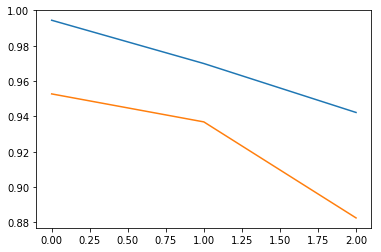


Epoch: 3, train loss: 0.942241770029068, val loss: 0.8825919508934021


100%|██████████| 20/20 [00:48<00:00,  2.50s/it]


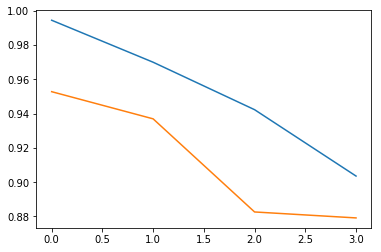


Epoch: 4, train loss: 0.9035311818122864, val loss: 0.8791187047958374


100%|██████████| 20/20 [00:48<00:00,  2.64s/it]


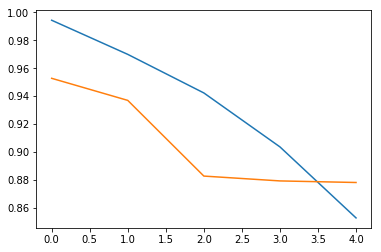


Epoch: 5, train loss: 0.852572163939476, val loss: 0.877988862991333


100%|██████████| 20/20 [00:47<00:00,  2.60s/it]


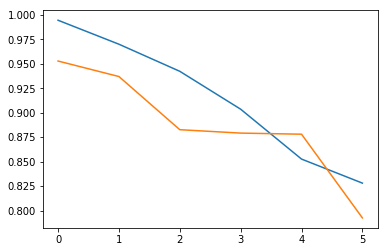


Epoch: 6, train loss: 0.8280102431774139, val loss: 0.7924691319465638


100%|██████████| 20/20 [00:42<00:00,  1.95s/it]


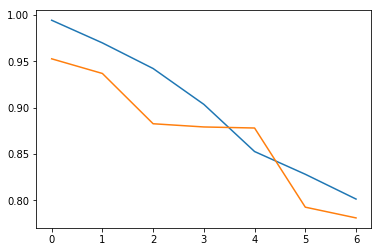


Epoch: 7, train loss: 0.8012238889932632, val loss: 0.7808583736419678


100%|██████████| 20/20 [00:44<00:00,  2.18s/it]


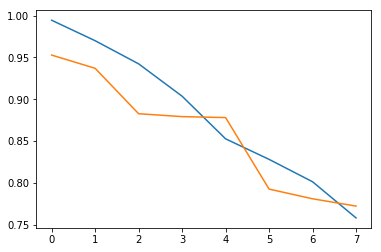


Epoch: 8, train loss: 0.7579782694578171, val loss: 0.7721195101737977


100%|██████████| 20/20 [00:46<00:00,  2.33s/it]


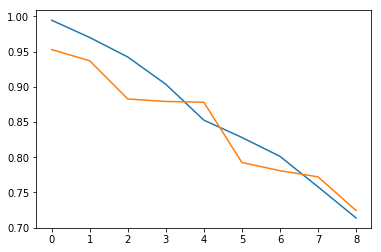


Epoch: 9, train loss: 0.7137959778308869, val loss: 0.7243854999542236


100%|██████████| 20/20 [00:46<00:00,  2.40s/it]


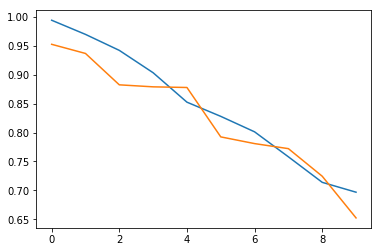


Epoch: 10, train loss: 0.696712189912796, val loss: 0.6521947145462036


100%|██████████| 20/20 [00:44<00:00,  2.35s/it]


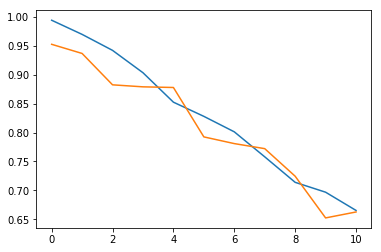


Epoch: 11, train loss: 0.6651467889547348, val loss: 0.6624741196632385


100%|██████████| 20/20 [00:46<00:00,  2.36s/it]


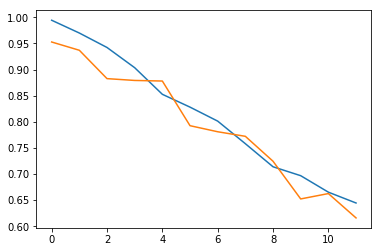


Epoch: 12, train loss: 0.6444113403558731, val loss: 0.6158427953720093


100%|██████████| 20/20 [00:47<00:00,  2.03s/it]


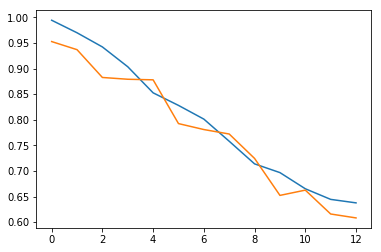


Epoch: 13, train loss: 0.637571918964386, val loss: 0.6081869721412658


100%|██████████| 20/20 [00:47<00:00,  2.82s/it]


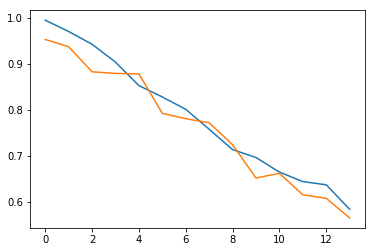


Epoch: 14, train loss: 0.5844015747308731, val loss: 0.5657163739204407


100%|██████████| 20/20 [00:45<00:00,  2.19s/it]


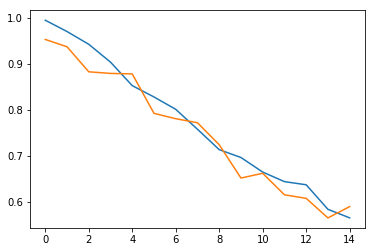


Epoch: 15, train loss: 0.5658467009663581, val loss: 0.5902450919151306


100%|██████████| 20/20 [00:42<00:00,  2.00s/it]


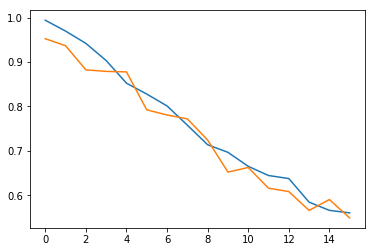


Epoch: 16, train loss: 0.5600971132516861, val loss: 0.5488190650939941


100%|██████████| 20/20 [00:46<00:00,  2.54s/it]


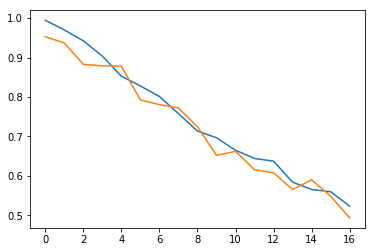


Epoch: 17, train loss: 0.5236341342329979, val loss: 0.4938212394714355


100%|██████████| 20/20 [00:45<00:00,  2.34s/it]


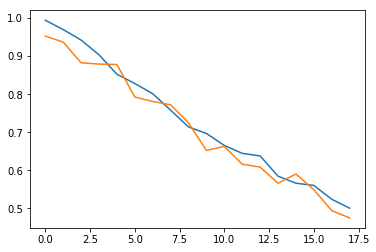


Epoch: 18, train loss: 0.5001900881528855, val loss: 0.4746128559112549


100%|██████████| 20/20 [00:50<00:00,  2.50s/it]


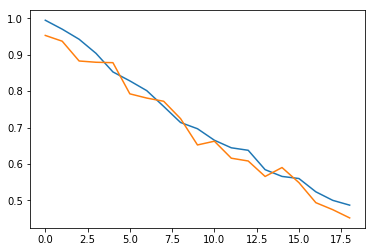


Epoch: 19, train loss: 0.48700255900621414, val loss: 0.45198684334754946


100%|██████████| 20/20 [00:48<00:00,  2.18s/it]


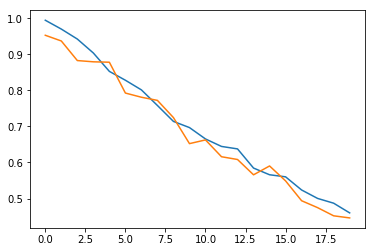


Epoch: 20, train loss: 0.46007910966873167, val loss: 0.44615288972854616


100%|██████████| 20/20 [00:48<00:00,  2.30s/it]


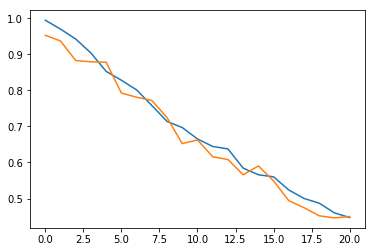


Epoch: 21, train loss: 0.4472702771425247, val loss: 0.4499197840690613


100%|██████████| 20/20 [00:49<00:00,  2.54s/it]


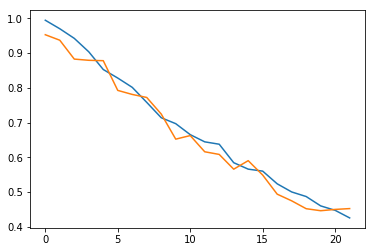


Epoch: 22, train loss: 0.42545358538627626, val loss: 0.45230166912078856


100%|██████████| 20/20 [00:48<00:00,  2.48s/it]


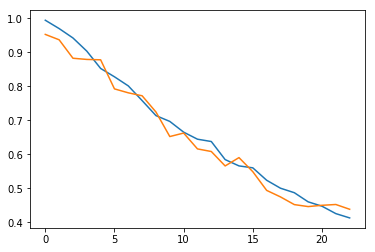


Epoch: 23, train loss: 0.41279805898666383, val loss: 0.43824275135993956


100%|██████████| 20/20 [00:45<00:00,  2.37s/it]


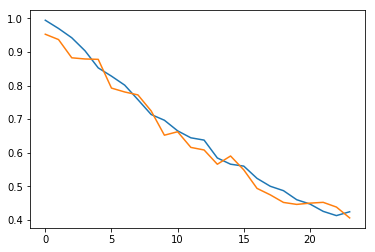


Epoch: 24, train loss: 0.42422239780426024, val loss: 0.4059182345867157


100%|██████████| 20/20 [00:46<00:00,  2.26s/it]


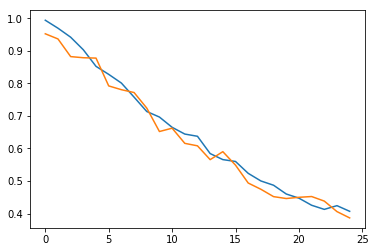


Epoch: 25, train loss: 0.40681112706661227, val loss: 0.3865238010883331


100%|██████████| 20/20 [00:44<00:00,  2.12s/it]


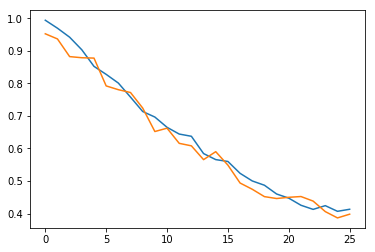


Epoch: 26, train loss: 0.4131367221474648, val loss: 0.39798918962478635


100%|██████████| 20/20 [00:46<00:00,  2.21s/it]


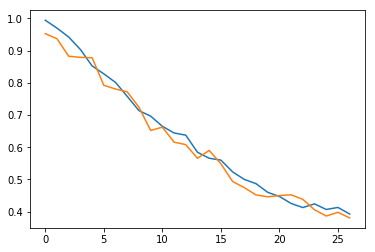


Epoch: 27, train loss: 0.3927346721291542, val loss: 0.3806100249290466


100%|██████████| 20/20 [00:47<00:00,  2.30s/it]


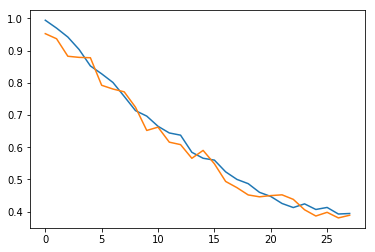


Epoch: 28, train loss: 0.39431578367948533, val loss: 0.38893675804138184


100%|██████████| 20/20 [00:52<00:00,  2.50s/it]


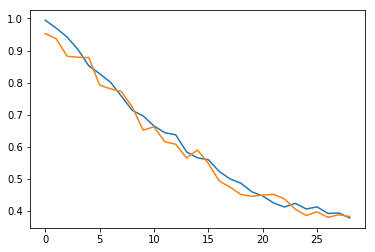


Epoch: 29, train loss: 0.37887626588344575, val loss: 0.3831656873226166


100%|██████████| 20/20 [00:45<00:00,  2.32s/it]


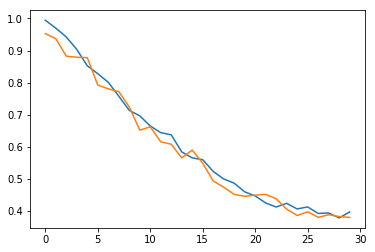


Epoch: 30, train loss: 0.3974456325173378, val loss: 0.38023810386657714


100%|██████████| 20/20 [00:45<00:00,  2.24s/it]


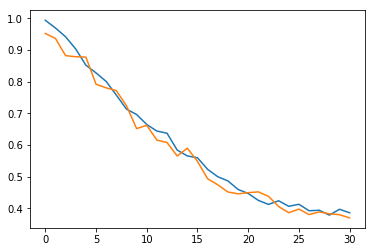


Epoch: 31, train loss: 0.3862297996878624, val loss: 0.37009645700454713


100%|██████████| 20/20 [00:43<00:00,  1.95s/it]


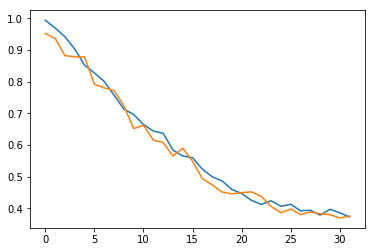


Epoch: 32, train loss: 0.37299673110246656, val loss: 0.3762202441692352


100%|██████████| 20/20 [00:48<00:00,  2.21s/it]


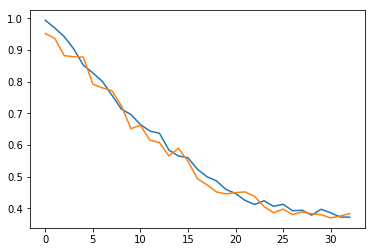


Epoch: 33, train loss: 0.3722982406616211, val loss: 0.3837788164615631


100%|██████████| 20/20 [00:47<00:00,  2.18s/it]


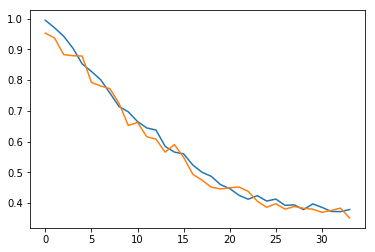


Epoch: 34, train loss: 0.37915078550577164, val loss: 0.3519392251968384


100%|██████████| 20/20 [00:50<00:00,  2.85s/it]


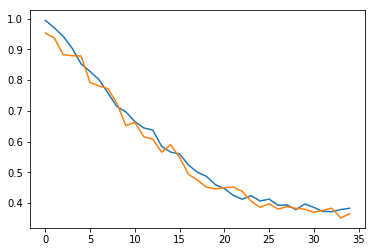


Epoch: 35, train loss: 0.3832408428192139, val loss: 0.365651935338974


100%|██████████| 20/20 [00:47<00:00,  2.58s/it]


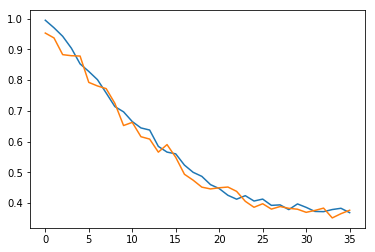


Epoch: 36, train loss: 0.3690444350242615, val loss: 0.3768826246261597


100%|██████████| 20/20 [00:45<00:00,  2.30s/it]


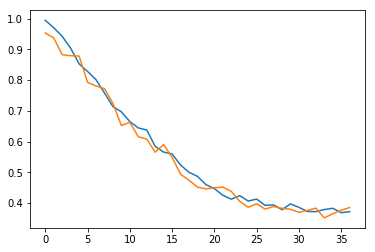


Epoch: 37, train loss: 0.37207412123680117, val loss: 0.3856493175029755


100%|██████████| 20/20 [00:49<00:00,  2.36s/it]


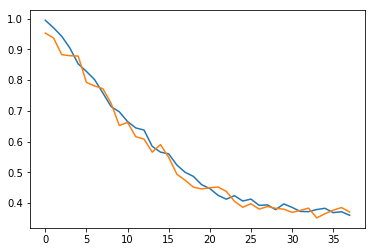


Epoch: 38, train loss: 0.3604907765984535, val loss: 0.37122411131858823


 20%|██        | 4/20 [00:09<00:38,  2.43s/it]

In [ ]:
from tqdm import tqdm
from matplotlib import pyplot as plt
train_l = []
val_l = []

for epoch in range(1, 200):
    if (epoch % 20 == 0 and epoch):
        l_r.set_value(lasagne.utils.floatX(l_r.get_value() / 10))
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    train_l += [train_loss]
    val_l += [val_loss]
    
    plt.plot(train_l)
    plt.plot(val_l)
    plt.show()
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    send('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

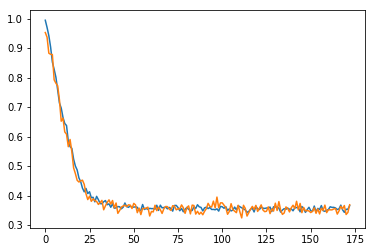

In [86]:
plt.plot(train_l)
plt.plot(val_l)
plt.show()

### apply trained model

In [87]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet_1 import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl', 'rb'), encoding='latin1')['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [88]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
# img = plt.imread('base.jpg')
img = preprocess(img)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


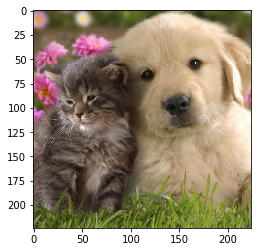

In [89]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [96]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [98]:
for i in range(10):
    print(' '.join(generate_caption(img,t=1.)[1:-1]))

little bear
baby cat long pink animal unhealthy type parents poorly
variety child toothbrushes
black puppy upright
red cat practicing she
cat
yellow furry cub tightly textured laptop twirling
dog
gray kitten cheetos small snack little person standng protruding red smart bear rolling an arms
cat little black cat feeds someones


# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 